In [2]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision import transforms
import medmnist
from medmnist import INFO

In [3]:
data_flag = "retinamnist"
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# load the data
_train_dataset = DataClass(split='train', transform=data_transform, download=download, root="../data/")
_valid_dataset = DataClass(split='val', transform=data_transform, download=download, root="../data/")
_test_dataset = DataClass(split='test', transform=data_transform, download=download, root="../data/")

dataset = ConcatDataset([_train_dataset, _valid_dataset, _test_dataset])

BATCH_SIZE = 128

train_loader = DataLoader(_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(_valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# train, test = torch.utils.data.random_split(dataset, [len(_train_dataset) + len(_valid_dataset), len(_test_dataset)])
# train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: ../data/retinamnist.npz
Using downloaded and verified file: ../data/retinamnist.npz
Using downloaded and verified file: ../data/retinamnist.npz


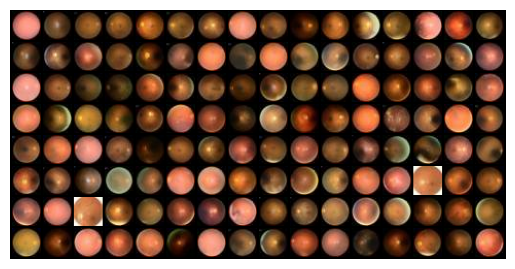

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

img_batch, _ = next(iter(train_loader))
plt.imshow(make_grid(img_batch, nrow=16).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
from src.model import VAE, SimpleCNNClassifier
from src.trainer import CDVAETrainer, SimpleCNNTrainer
from src.model import interpolate_latent

%load_ext autoreload
%autoreload 2

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [46]:
cnn = SimpleCNNClassifier(n_class=5, in_channel=3).to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = SimpleCNNTrainer(cnn, optimizer, criterion, 20, device, transform)

In [47]:
trainer.fit(101, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 1/1 [00:00<00:00, 70.40it/s]


val_aupr: {0: 0.676, 1: 0.088, 2: 0.291, 3: 0.199, 4: 0.107}
0.272
val_auroc: {0: 0.693, 1: 0.4, 2: 0.626, 3: 0.457, 4: 0.599}
0.555


val-epoch 20: 100%|██████████| 1/1 [00:00<00:00, 141.79it/s]


val_aupr: {0: 0.87, 1: 0.224, 2: 0.495, 3: 0.378, 4: 0.3}
0.453
val_auroc: {0: 0.824, 1: 0.753, 2: 0.829, 3: 0.76, 4: 0.801}
0.793


val-epoch 40: 100%|██████████| 1/1 [00:00<00:00, 154.75it/s]


val_aupr: {0: 0.862, 1: 0.252, 2: 0.521, 3: 0.366, 4: 0.311}
0.462
val_auroc: {0: 0.818, 1: 0.76, 2: 0.83, 3: 0.748, 4: 0.819}
0.795


val-epoch 60: 100%|██████████| 1/1 [00:00<00:00, 140.59it/s]


val_aupr: {0: 0.851, 1: 0.351, 2: 0.523, 3: 0.348, 4: 0.366}
0.488
val_auroc: {0: 0.793, 1: 0.748, 2: 0.825, 3: 0.748, 4: 0.806}
0.784


val-epoch 80: 100%|██████████| 1/1 [00:00<00:00, 156.24it/s]


val_aupr: {0: 0.857, 1: 0.263, 2: 0.47, 3: 0.276, 4: 0.384}
0.45
val_auroc: {0: 0.808, 1: 0.741, 2: 0.801, 3: 0.732, 4: 0.826}
0.782


val-epoch 100: 100%|██████████| 1/1 [00:00<00:00, 123.01it/s]

val_aupr: {0: 0.843, 1: 0.24, 2: 0.486, 3: 0.269, 4: 0.432}
0.454
val_auroc: {0: 0.777, 1: 0.727, 2: 0.798, 3: 0.716, 4: 0.845}
0.773


In [48]:
trainer._valid(test_loader, True, 0)

val-epoch 0: 100%|██████████| 4/4 [00:00<00:00, 174.92it/s]

val_aupr: {0: 0.817, 1: 0.181, 2: 0.344, 3: 0.374, 4: 0.118}
0.367
val_auroc: {0: 0.846, 1: 0.63, 2: 0.697, 3: 0.778, 4: 0.715}
0.733


In [49]:
from sklearn.manifold import TSNE

In [50]:
hs = []
labels = []
with torch.no_grad():
    for X, label in tqdm(train_loader):
        X = X.to(device)
        label = label.to(device)

        h = cnn.net(X)
        hs.append(h)
        labels.append(label)

hs = torch.cat(hs, dim=0)
labels = torch.cat(labels, dim=0)


tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
hs_tsne = tsne.fit_transform(hs.cpu().numpy())

100%|██████████| 9/9 [00:00<00:00, 121.98it/s]


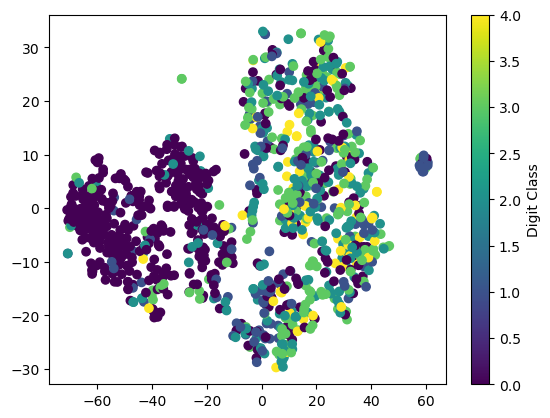

In [51]:
plt.scatter(hs_tsne[:, 0], hs_tsne[:, 1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [76]:
Z_DIM = 32
TEMP = 0.1
ALPHA = [5, 5]
LABEL_FLIPPING = True
vae = VAE(total_z_dim=Z_DIM, in_channel=3).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=2e-4, weight_decay=1e-2)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=30,
    device=device,
    transform=transform
)

In [77]:
trainer.fit(391, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 1/1 [00:00<00:00, 133.53it/s]


val_recontr_loss=307.581, val_kl_c=0.003, val_kl_s=0.007, val_c_loss=1.321, val_s_loss=0.371
gMIG: 0.019


val-epoch 30: 100%|██████████| 1/1 [00:00<00:00, 103.47it/s]


val_recontr_loss=149.454, val_kl_c=2.281, val_kl_s=2.206, val_c_loss=1.059, val_s_loss=0.401
gMIG: 0.073


val-epoch 60: 100%|██████████| 1/1 [00:00<00:00, 140.79it/s]


val_recontr_loss=117.097, val_kl_c=2.072, val_kl_s=1.906, val_c_loss=1.002, val_s_loss=0.419
gMIG: 0.061


val-epoch 90: 100%|██████████| 1/1 [00:00<00:00, 235.29it/s]


val_recontr_loss=107.337, val_kl_c=1.945, val_kl_s=1.854, val_c_loss=1.009, val_s_loss=0.421
gMIG: 0.058


val-epoch 120: 100%|██████████| 1/1 [00:00<00:00, 90.06it/s]


val_recontr_loss=93.070, val_kl_c=1.916, val_kl_s=1.772, val_c_loss=1.014, val_s_loss=0.422
gMIG: 0.081


val-epoch 150: 100%|██████████| 1/1 [00:00<00:00, 116.45it/s]


val_recontr_loss=88.109, val_kl_c=1.834, val_kl_s=1.696, val_c_loss=0.998, val_s_loss=0.446
gMIG: 0.076


val-epoch 180: 100%|██████████| 1/1 [00:00<00:00, 152.10it/s]


val_recontr_loss=84.534, val_kl_c=1.754, val_kl_s=1.732, val_c_loss=0.997, val_s_loss=0.414
gMIG: 0.067


val-epoch 210: 100%|██████████| 1/1 [00:00<00:00, 84.87it/s]


val_recontr_loss=71.436, val_kl_c=1.629, val_kl_s=1.651, val_c_loss=0.971, val_s_loss=0.417
gMIG: 0.076


val-epoch 240: 100%|██████████| 1/1 [00:00<00:00, 118.32it/s]


val_recontr_loss=62.808, val_kl_c=1.629, val_kl_s=1.615, val_c_loss=0.994, val_s_loss=0.438
gMIG: 0.072


val-epoch 270: 100%|██████████| 1/1 [00:00<00:00, 100.64it/s]


val_recontr_loss=59.306, val_kl_c=1.556, val_kl_s=1.597, val_c_loss=0.965, val_s_loss=0.459
gMIG: 0.073


val-epoch 300: 100%|██████████| 1/1 [00:00<00:00, 99.47it/s]


val_recontr_loss=52.662, val_kl_c=1.540, val_kl_s=1.596, val_c_loss=0.976, val_s_loss=0.447
gMIG: 0.055


val-epoch 330: 100%|██████████| 1/1 [00:00<00:00, 113.34it/s]


val_recontr_loss=49.549, val_kl_c=1.459, val_kl_s=1.555, val_c_loss=1.008, val_s_loss=0.475
gMIG: 0.065


val-epoch 360: 100%|██████████| 1/1 [00:00<00:00, 118.97it/s]


val_recontr_loss=43.723, val_kl_c=1.347, val_kl_s=1.586, val_c_loss=1.003, val_s_loss=0.446
gMIG: 0.064


val-epoch 390: 100%|██████████| 1/1 [00:00<00:00, 96.41it/s]


val_recontr_loss=39.127, val_kl_c=1.375, val_kl_s=1.571, val_c_loss=0.999, val_s_loss=0.490
gMIG: 0.07


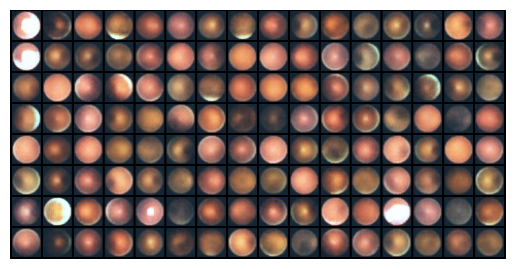

In [66]:
X, _ = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, _, _ = vae(X.clone(), explicit=True)

plt.imshow(make_grid(X_hat, nrow=16).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

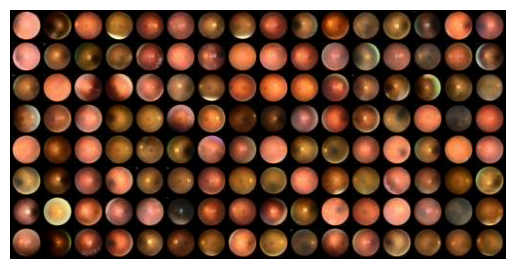

In [67]:
plt.imshow(make_grid(X, nrow=16).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

In [78]:
mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for _ in tqdm(range(1)):
        for X, label in train_loader:
            # X = transform(X)
            X, label = X.to(device), label.to(device)

            _, latent_params = vae(X)
            mu_cs.append(latent_params['mu_c'])
            mu_ss.append(latent_params['mu_s'])
            labels.append(label)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


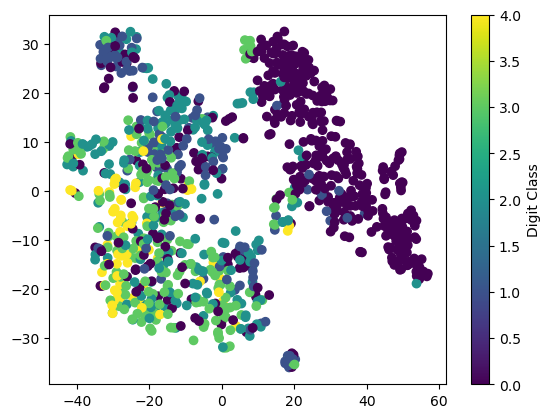

In [79]:
plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [80]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

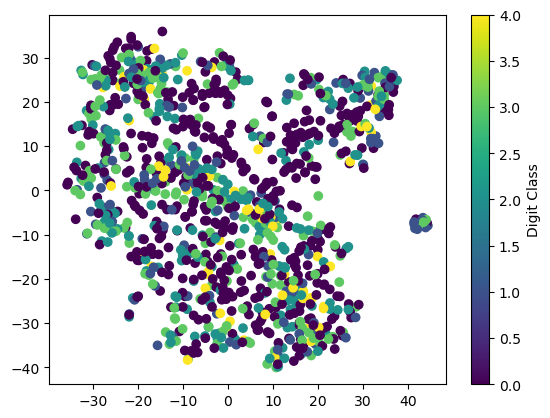

In [81]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [82]:
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

In [88]:
from src.trainer import DownstreamMLPTrainer
mlp = torch.nn.Sequential(
    torch.nn.Linear(int(Z_DIM / 2), 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 5),
).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = DownstreamMLPTrainer(vae, mlp, optimizer, criterion, 20, device, transform)
trainer.fit(121, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 1/1 [00:00<00:00, 175.41it/s]


val_aupr: {0: 0.576, 1: 0.077, 2: 0.233, 3: 0.147, 4: 0.051}
0.217
val_auroc: {0: 0.615, 1: 0.33, 2: 0.516, 3: 0.448, 4: 0.33}
0.448


val-epoch 20: 100%|██████████| 1/1 [00:00<00:00, 135.41it/s]


val_aupr: {0: 0.886, 1: 0.116, 2: 0.414, 3: 0.264, 4: 0.078}
0.352
val_auroc: {0: 0.845, 1: 0.549, 2: 0.715, 3: 0.719, 4: 0.646}
0.695


val-epoch 40: 100%|██████████| 1/1 [00:00<00:00, 246.09it/s]


val_aupr: {0: 0.89, 1: 0.176, 2: 0.465, 3: 0.281, 4: 0.118}
0.386
val_auroc: {0: 0.851, 1: 0.681, 2: 0.738, 3: 0.731, 4: 0.744}
0.749


val-epoch 60: 100%|██████████| 1/1 [00:00<00:00, 136.30it/s]


val_aupr: {0: 0.887, 1: 0.186, 2: 0.524, 3: 0.284, 4: 0.181}
0.412
val_auroc: {0: 0.847, 1: 0.715, 2: 0.764, 3: 0.73, 4: 0.787}
0.769


val-epoch 80: 100%|██████████| 1/1 [00:00<00:00, 141.48it/s]


val_aupr: {0: 0.882, 1: 0.197, 2: 0.556, 3: 0.284, 4: 0.194}
0.423
val_auroc: {0: 0.841, 1: 0.729, 2: 0.773, 3: 0.73, 4: 0.813}
0.777


val-epoch 100: 100%|██████████| 1/1 [00:00<00:00, 244.77it/s]


val_aupr: {0: 0.881, 1: 0.205, 2: 0.545, 3: 0.278, 4: 0.294}
0.441
val_auroc: {0: 0.842, 1: 0.734, 2: 0.773, 3: 0.722, 4: 0.836}
0.781


val-epoch 120: 100%|██████████| 1/1 [00:00<00:00, 123.81it/s]

val_aupr: {0: 0.879, 1: 0.205, 2: 0.541, 3: 0.281, 4: 0.304}
0.442
val_auroc: {0: 0.841, 1: 0.732, 2: 0.769, 3: 0.72, 4: 0.845}
0.781


In [89]:
trainer._valid(test_loader, True, 0)

val-epoch 0: 100%|██████████| 4/4 [00:00<00:00, 127.83it/s]

val_aupr: {0: 0.805, 1: 0.253, 2: 0.366, 3: 0.328, 4: 0.109}
0.372
val_auroc: {0: 0.84, 1: 0.671, 2: 0.705, 3: 0.768, 4: 0.746}
0.746
